In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

#acquire
import acquire
import prepare
from env import host, username, password
from pydataset import data
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans


# Acquire & Prep Data

## Acquire data - zillow_data()

In [2]:
df = acquire.zillow_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77580 entries, 0 to 77579
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        223 non-null    float64
 1   storytypeid                   50 non-null     float64
 2   propertylandusetypeid         77580 non-null  float64
 3   heatingorsystemtypeid         49572 non-null  float64
 4   buildingclasstypeid           15 non-null     float64
 5   architecturalstyletypeid      207 non-null    float64
 6   airconditioningtypeid         25007 non-null  float64
 7   parcelid                      77580 non-null  int64  
 8   id                            77580 non-null  int64  
 9   logerror                      77580 non-null  float64
 10  transactiondate               77580 non-null  object 
 11  id                            77580 non-null  int64  
 12  basementsqft                  50 non-null     float64
 13  b

## Prep Zillow Data - prepare_zillow()

In [4]:
df.propertylandusedesc.value_counts()

Single Family Residential                     52442
Condominium                                   19342
Duplex (2 Units, Any Combination)              2021
Planned Unit Development                       1947
Quadruplex (4 Units, Any Combination)           729
Triplex (3 Units, Any Combination)              539
Cluster Home                                    335
Mobile Home                                      74
Manufactured, Modular, Prefabricated Homes       59
Residential General                              42
Cooperative                                      29
Commercial/Office/Residential Mixed Used         15
Townhouse                                         6
Name: propertylandusedesc, dtype: int64

***
Single unit properties - Single Family Residential, Mobile Home, Manufactured, Modular, Prefabricated Homes, Townhouse
* Townhouse only has 6 so drop
***

In [5]:
# Restrict propertylandusedesc to those of single unit
df = df[(df.propertylandusedesc == 'Single Family Residential') | 
        (df.propertylandusedesc == 'Mobile Home') |
        (df.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes')]

In [6]:
# null values
df.isnull().sum()

typeconstructiontypeid          52499
storytypeid                     52528
propertylandusetypeid               0
heatingorsystemtypeid           18639
buildingclasstypeid             52575
architecturalstyletypeid        52505
airconditioningtypeid           38935
parcelid                            0
id                                  0
logerror                            0
transactiondate                     0
id                                  0
basementsqft                    52528
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           18783
calculatedbathnbr                 175
decktypeid                      52183
finishedfloor1squarefeet        48184
calculatedfinishedsquarefeet      102
finishedsquarefeet12              309
finishedsquarefeet13            52533
finishedsquarefeet15            52575
finishedsquarefeet50            48184
finishedsquarefeet6             52410
fips                                0
fireplacecnt

In [7]:
# dropping cols/rows where more than half of the values are null
df = acquire.handle_missing_values(df, col_perc = .5, row_perc = .5)

In [8]:
# dropping the columns with 17K missing values too much to fill/impute/drop rows
df = df.drop(columns=['heatingorsystemtypeid', 'buildingqualitytypeid', 'propertyzoningdesc', 'unitcnt', 'heatingorsystemdesc'])

In [9]:
# organize features with missing data by discrete & continuous in order to impute missing data
discrete_col = ['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'censustractandblock']
cont_col = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']

In [10]:
# single outlier in transactiondate
df.transactiondate.sort_values(ascending=False)

77579    2018-05-25
77578    2017-09-25
77577    2017-09-21
77576    2017-09-21
77575    2017-09-20
            ...    
7        2017-01-01
6        2017-01-01
3        2017-01-01
2        2017-01-01
0        2017-01-01
Name: transactiondate, Length: 52575, dtype: object

In [11]:
df.transactiondate.describe()

count          52575
unique           258
top       2017-06-30
freq             814
Name: transactiondate, dtype: object

In [12]:
# address date outlier by replacing with mode
df['transactiondate'] = df.transactiondate.replace('2018-05-25', '2017-06-30')

In [13]:
# Convert transactiondate to datetime
df['transactiondate'] = pd.to_datetime(df.transactiondate)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52575 entries, 0 to 77579
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   propertylandusetypeid         52575 non-null  float64       
 1   parcelid                      52575 non-null  int64         
 2   id                            52575 non-null  int64         
 3   logerror                      52575 non-null  float64       
 4   transactiondate               52575 non-null  datetime64[ns]
 5   id                            52575 non-null  int64         
 6   bathroomcnt                   52575 non-null  float64       
 7   bedroomcnt                    52575 non-null  float64       
 8   calculatedbathnbr             52400 non-null  float64       
 9   calculatedfinishedsquarefeet  52473 non-null  float64       
 10  finishedsquarefeet12          52266 non-null  float64       
 11  fips                        

In [14]:
# drop assessment year as it is one single year
df = df.drop(columns=(['assessmentyear']))

In [15]:
#dropping the id columns, as parcelid is a unique identifier
df= df.drop(columns=('id'))

In [16]:
df.isnull().sum()

propertylandusetypeid              0
parcelid                           0
logerror                           0
transactiondate                    0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr                175
calculatedfinishedsquarefeet     102
finishedsquarefeet12             309
fips                               0
fullbathcnt                      175
latitude                           0
longitude                          0
lotsizesquarefeet                375
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1037
regionidcounty                     0
regionidzip                       27
roomcnt                            0
yearbuilt                        135
structuretaxvaluedollarcnt        96
taxvaluedollarcnt                  1
landtaxvaluedollarcnt              2
taxamount                          4
censustractandblock              123
propertylandusedesc                0
d

In [17]:
# Convert logerror to absolute value
df['logerror'] = df.logerror.abs()

### FIPS data manipulation

In [18]:
# convert fips to integer to drop decimals before converting to string
df['fips'] = df['fips'].astype(int)

In [19]:
# convert fips data to string so that we can split
df['fips'] = df['fips'].astype('str')

In [20]:
# confirm
df.fips.dtype

dtype('O')

In [21]:
# Create County column by stripping state reference location(last three digits)
df['county'] = df['fips'].str[1:]

In [22]:
# check to see how many different counties
df.county.value_counts()

037    33966
059    14145
111     4464
Name: county, dtype: int64

In [23]:
# Replace numerics with labels
df['county'] = df['county'].replace({'037':'Los Angeles', '059':'Orange', '111':'Ventura'})

In [24]:
# control check on manipulation
df.county.value_counts()

Los Angeles    33966
Orange         14145
Ventura         4464
Name: county, dtype: int64

***
#### Notes on fips:
* fips codes in zillow data missing the leading zero for the state code first two digit assignment.  Only reason discovered this was by looking up standard fips codes are 5 digit...data only pro#### Calculate Tax Ratevides 
* first 2 numerics = state, last 3 numerics = county
* only 1 state code and 3 county codes in zillow dataframe

look up code references and construct new columns identifying state and counties (source: https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt)
* State codes: 01 = CA
* County codes: 037=Los Angeles County, 059=Orange County & 111=Ventura County 
***

### Calculate Tax Rate

In [25]:
df['tax_rate'] = round((df.taxamount / df.taxvaluedollarcnt), 3)

In [26]:
df.tax_rate.describe()

count    52570.000000
mean         0.013352
std          0.006677
min          0.000000
25%          0.012000
50%          0.012000
75%          0.014000
max          0.816000
Name: tax_rate, dtype: float64

In [27]:
df.tax_rate.sort_values(ascending=False).head(10)

62060    0.816
73329    0.494
45856    0.453
8711     0.346
33148    0.295
36626    0.278
43099    0.204
39641    0.183
77506    0.179
43970    0.148
Name: tax_rate, dtype: float64

In [28]:
# drop the rows with tax rates in excess of 0.2
df = df.drop(df[df['tax_rate']>0.2].index)

In [29]:
df.tax_rate.describe()

count    52563.000000
mean         0.013299
std          0.004314
min          0.000000
25%          0.012000
50%          0.012000
75%          0.014000
max          0.183000
Name: tax_rate, dtype: float64

***
#### Notes on Tax Rate: Now that we have a calculated tax_rate should be easier to detect outliers
* no negative values 
* max didn't pass the smell test.  While some of the calculated tax rates seemed high, there were 3 in particular that stuck out at 45%, 49% & 81%. While other values did appear off, I decided to only cut these two as they were completely in a dimension of their own.
***

In [30]:
# organize features with missing data by discrete & continuous in order to impute missing data
discrete_col = ['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'censustractandblock']
cont_col = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'tax_rate']

In [31]:
# Split data
train, validate, test = acquire.split_continuous(df)

train -> (29437, 29)
validate -> (12617, 29)
test -> (10514, 29)


In [32]:
# impute mode on discrete columns in split data
imputer = SimpleImputer(strategy='most_frequent')
train[discrete_col] = imputer.fit_transform(train[discrete_col])
validate[discrete_col] = imputer.transform(validate[discrete_col])
test[discrete_col] = imputer.transform(test[discrete_col])

In [33]:
# impute mean on continuous columns in split data
imputer = SimpleImputer(strategy='mean')
train[cont_col] = imputer.fit_transform(train[cont_col])
validate[cont_col] = imputer.transform(validate[cont_col])
test[cont_col] = imputer.transform(test[cont_col])

In [34]:
#control test
test.isnull().sum()

propertylandusetypeid           0
parcelid                        0
logerror                        0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
propertylandusedesc             0
county                          0
tax_rate                        0
dtype: int64

### Control check to make sure we've addressed nulls

In [35]:
train.isnull().sum()

propertylandusetypeid           0
parcelid                        0
logerror                        0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
propertylandusedesc             0
county                          0
tax_rate                        0
dtype: int64

In [36]:
train.shape, validate.shape, test.shape

((29437, 29), (12617, 29), (10514, 29))

***
Note: I acquired and prepped the data above but after reviewing my data and trying to game plan, I decide to pare down collinearity by eliminating redundant information
***

### Review collinearity amongst independent variables

In [37]:
# Separate variables by associations, adding in target
sqft = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12']
bath = ['bathroomcnt', 'fullbathcnt', 'bedroomcnt', 'calculatedbathnbr']
value = ['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']
loc = ['latitude', 'longitude', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidzip', 'censustractandblock']

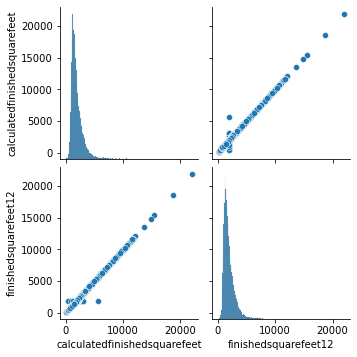

In [38]:
sns.pairplot(data = train[sqft])

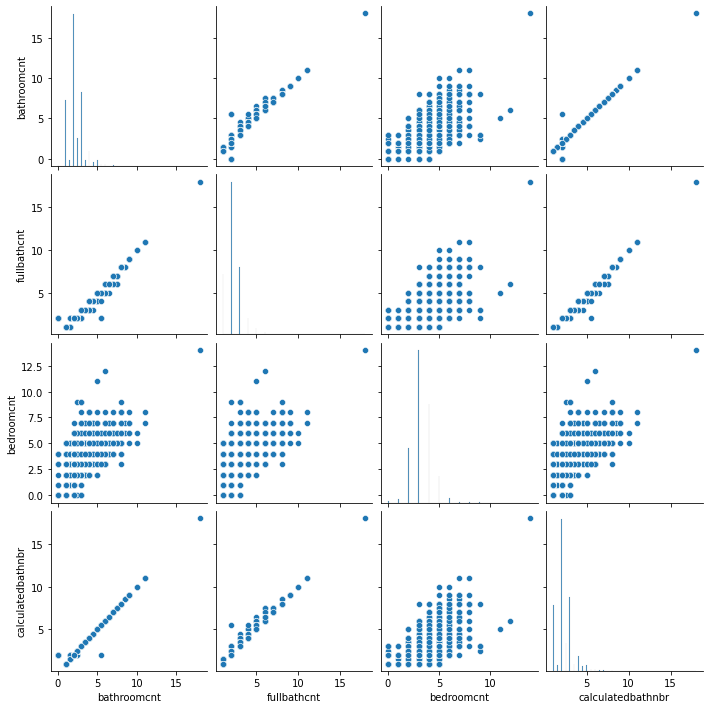

In [39]:
sns.pairplot(data = train[bath])

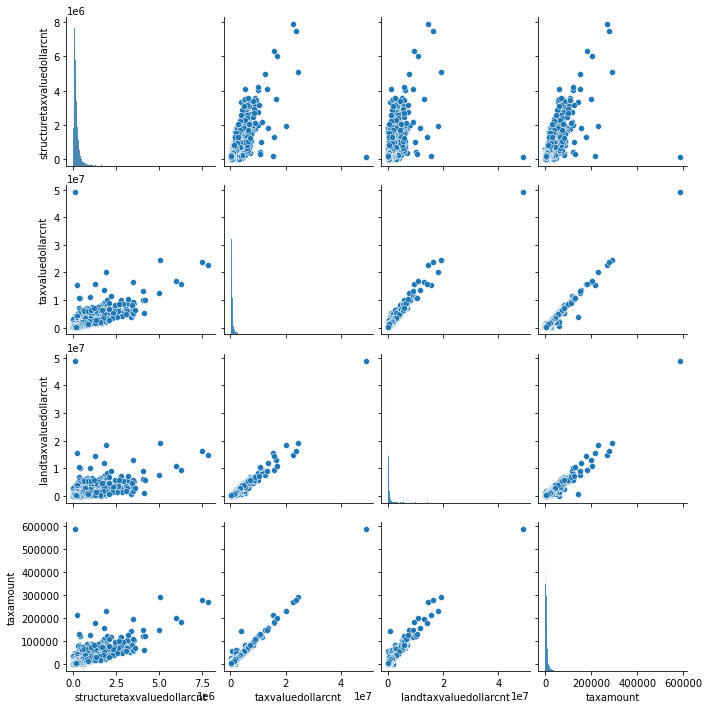

In [40]:
sns.pairplot(data = train[value])

In [41]:
train[sqft].corr()

,calculatedfinishedsquarefeet,finishedsquarefeet12
calculatedfinishedsquarefeet,1.000000,0.998194
finishedsquarefeet12,0.998194,1.000000


In [42]:
train[bath].corr()

,bathroomcnt,fullbathcnt,bedroomcnt,calculatedbathnbr
bathroomcnt,1.000000,0.979490,0.652559,0.993995
fullbathcnt,0.979490,1.000000,0.629637,0.985724
bedroomcnt,0.652559,0.629637,1.000000,0.638486
calculatedbathnbr,0.993995,0.985724,0.638486,1.000000


In [43]:
train[value].corr()

,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
structuretaxvaluedollarcnt,1.000000,0.778119,0.587853,0.776153
taxvaluedollarcnt,0.778119,1.000000,0.965479,0.990652
landtaxvaluedollarcnt,0.587853,0.965479,1.000000,0.954369
taxamount,0.776153,0.990652,0.954369,1.000000


In [44]:
train[loc].corr()

,latitude,longitude,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,censustractandblock
latitude,1.000000,-0.546242,-0.063137,-0.018695,0.589190,0.013241,-0.008679
longitude,-0.546242,1.000000,-0.373804,0.003727,-0.372993,0.028576,-0.029205
rawcensustractandblock,-0.063137,-0.373804,1.000000,-0.036745,-0.598863,0.028576,0.081234
regionidcity,-0.018695,0.003727,-0.036745,1.000000,0.058236,-0.011613,-0.005775
regionidcounty,0.589190,-0.372993,-0.598863,0.058236,1.000000,-0.035269,-0.046451
regionidzip,0.013241,0.028576,0.028576,-0.011613,-0.035269,1.000000,0.001922
censustractandblock,-0.008679,-0.029205,0.081234,-0.005775,-0.046451,0.001922,1.000000


In [45]:
train.censustractandblock.nunique()

20987

In [46]:
# drop corrlated columns from split data
train = train.drop(columns=(['finishedsquarefeet12', 'landtaxvaluedollarcnt', 'taxamount', 'calculatedbathnbr', 'fullbathcnt']))
validate = validate.drop(columns=(['finishedsquarefeet12', 'landtaxvaluedollarcnt', 'taxamount', 'calculatedbathnbr', 'fullbathcnt']))
test = test.drop(columns=(['finishedsquarefeet12', 'landtaxvaluedollarcnt', 'taxamount', 'calculatedbathnbr', 'fullbathcnt']))

In [47]:
print(train.shape, validate.shape, test.shape)

(29437, 24) (12617, 24) (10514, 24)


***
#### Key Takeaways: 

* calculatedfinishedsquarefeet & finishedsquarefeet12 highly correlated 
    * drop finishedsquarefeet12  
* calculatedbathnbr hihgly correlated with bathroomcnt less so with bedroomcnt
    * going to drop all except bathroomcnt & bedroomcnt 
* taxvaluedollarcount highly correlated with all others in this group     
    * correlation b/w taxvaluedollarcnt & structuretaxvaluedollarcnt weaker, keep these two and drop others       
* Not able to deal w/location features using correlation
       
***

# Feature Engineering

In [48]:
train.corr().sort_values('logerror', ascending=False)

,propertylandusetypeid,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,censustractandblock,tax_rate
logerror,0.022296,-0.020738,1.000000,0.007256,-0.016024,0.045016,-0.013074,-0.007079,0.010984,-0.033006,0.002248,0.021074,-0.000153,-0.026934,-0.087245,0.034174,0.058520,0.001257,0.022493
taxvaluedollarcnt,-0.017369,0.003685,0.058520,0.505837,0.273278,0.598464,-0.112368,-0.036214,0.020201,0.013550,-0.023701,-0.049483,0.027974,-0.015156,0.155719,0.778119,1.000000,0.001847,-0.184715
calculatedfinishedsquarefeet,-0.015048,0.052873,0.045016,0.847356,0.626006,1.000000,-0.036447,-0.008276,0.037312,0.105164,-0.044948,-0.133624,0.034099,0.072213,0.449450,0.752268,0.598464,0.006060,-0.143388
structuretaxvaluedollarcnt,-0.017707,0.022502,0.034174,0.642091,0.375172,0.752268,-0.030085,-0.057281,0.033635,0.058363,-0.036241,-0.043444,0.027120,-0.048209,0.339017,1.000000,0.778119,0.003233,-0.157105
tax_rate,-0.015902,-0.064724,0.022493,-0.137847,-0.077647,-0.143388,0.225116,0.012958,-0.010554,-0.180783,0.001780,0.214048,-0.004367,-0.186389,-0.048375,-0.157105,-0.184715,-0.018550,1.000000
propertylandusetypeid,1.000000,0.038408,0.022296,-0.042916,-0.079040,-0.015048,0.033890,-0.080285,0.002637,0.096182,0.004698,-0.017458,0.003274,0.000585,0.025654,-0.017707,-0.017369,0.007933,-0.015902
regionidcounty,-0.017458,-0.346725,0.021074,-0.135124,-0.131293,-0.133624,0.589190,-0.372993,0.024368,-0.598863,0.058236,1.000000,-0.035269,-0.748886,-0.344691,-0.043444,-0.049483,-0.046451,0.214048
lotsizesquarefeet,0.002637,-0.010746,0.010984,0.024829,0.004910,0.037312,0.060221,-0.015485,1.000000,-0.005693,-0.009763,0.024368,0.010920,-0.013703,0.037453,0.033635,0.020201,-0.000866,-0.010554
bathroomcnt,-0.042916,0.048407,0.007256,1.000000,0.652559,0.847356,-0.010969,-0.003039,0.024829,0.099185,-0.048220,-0.135124,0.031991,0.071039,0.516856,0.642091,0.505837,0.006685,-0.137847
regionidcity,0.004698,-0.021500,0.002248,-0.048220,-0.040371,-0.044948,-0.018695,0.003727,-0.009763,-0.036745,1.000000,0.058236,-0.011613,-0.043305,-0.078809,-0.036241,-0.023701,-0.005775,0.001780


***
Key Takeaways: 
* Location matters: longitude, latitude and County appear to correlated to logerror
* Value matters: taxdollarcnt has 2nd strongest correlations
* Size matters most: calculatedsquarefeet, bedroomcnt & bathrmcnt have the strongest correlations with logerror
    * create new feature bedroomcnt and bathrmcnt per sq ft
* Year built most significant factor
***

### Create new features using calculatedfinishedsquarefeet

In [49]:
# combine sqft with highly correlated features in order to eliminate noise
train['bedsqft'] = train.bedroomcnt/train.calculatedfinishedsquarefeet
train['bathsqft'] = train.bathroomcnt/train.calculatedfinishedsquarefeet
train['pricesqft'] = train.taxvaluedollarcnt/train.calculatedfinishedsquarefeet
validate['bedsqft'] = validate.bedroomcnt/validate.calculatedfinishedsquarefeet
validate['bathsqft'] = validate.bathroomcnt/validate.calculatedfinishedsquarefeet
validate['pricesqft'] = validate.taxvaluedollarcnt/validate.calculatedfinishedsquarefeet
test['bedsqft'] = test.bedroomcnt/test.calculatedfinishedsquarefeet
test['bathsqft'] = test.bathroomcnt/test.calculatedfinishedsquarefeet
test['pricesqft'] = test.taxvaluedollarcnt/test.calculatedfinishedsquarefeet

### Bin logerror into quartiles

In [50]:
# Create log quartile column to separate logerror extremes and identify trends
log_quantile = [1,2,3,4]
train['log_quartile'] = pd.qcut(train['logerror'], q=[0,.25,.5,.75,1], labels = log_quantile)
validate['log_quartile'] = pd.qcut(validate['logerror'], q=[0,.25,.5,.75,1], labels = log_quantile)
test['log_quartile'] = pd.qcut(test['logerror'], q=[0,.25,.5,.75,1], labels = log_quantile)

### Divide taxvaluedollarcnt into General Market & Premium market

In [51]:
# Evaluate and break housing data into general and premium market
train.taxvaluedollarcnt.describe()

count    2.943700e+04
mean     5.310097e+05
std      7.842343e+05
min      1.108900e+04
25%      1.927000e+05
50%      3.743700e+05
75%      6.200000e+05
max      4.906124e+07
Name: taxvaluedollarcnt, dtype: float64

In [52]:
# First 3 quartiles
train.logerror[train['taxvaluedollarcnt']<620000].describe()

count    22069.000000
mean         0.071070
std          0.153120
min          0.000002
25%          0.013847
50%          0.031748
75%          0.069194
max          3.100913
Name: logerror, dtype: float64

In [53]:
# Last quartile
train.logerror[train['taxvaluedollarcnt']>620000].describe()

count    7358.000000
mean        0.082645
std         0.200994
min         0.000007
25%         0.015866
50%         0.036799
75%         0.077062
max         5.262999
Name: logerror, dtype: float64

In [54]:
# Create Boolean Column for general market = <620000 which covers first 3 quartiles
train['value_generalmkt'] = train['taxvaluedollarcnt']<620000
validate['value_generalmkt'] = validate['taxvaluedollarcnt']<620000
test['value_generalmkt'] = test['taxvaluedollarcnt']<620000

In [55]:
# Convert Bools into 1 & 0
train['value_generalmkt'] = train.value_generalmkt.replace({False:0, True:1})
validate['value_generalmkt'] = validate.value_generalmkt.replace({False:0, True:1})
test['value_generalmkt'] = test.value_generalmkt.replace({False:0, True:1})

In [56]:
validate.value_generalmkt.head()

43877    1
53884    1
39110    0
63303    1
28522    1
Name: value_generalmkt, dtype: int64

## Scale data

#### Columns to scale

In [57]:
train.columns

Index(['propertylandusetypeid', 'parcelid', 'logerror', 'transactiondate',
       'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips',
       'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'censustractandblock', 'propertylandusedesc', 'county', 'tax_rate',
       'bedsqft', 'bathsqft', 'pricesqft', 'log_quartile', 'value_generalmkt'],
      dtype='object')

In [58]:
cols_to_scale = ['logerror', 'calculatedfinishedsquarefeet', 'latitude', 'longitude', 'taxvaluedollarcnt', 'tax_rate', 'bedsqft', 'bathsqft', 'pricesqft', 'age']

#### Convert yearbuilt to age in order to scale

In [59]:
train['age'] = 2017 - train.yearbuilt
validate['age'] = 2017 - validate.yearbuilt
test['age'] = 2017 - test.yearbuilt

In [60]:
### Min Max Scaler 
train_scaled, validate_scaled, test_scaled = prepare.min_max_scale(train, validate, test, cols_to_scale)

In [61]:
# Control Test
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((29437, 10), (12617, 10), (10514, 10))

#### Concat scaled data w/explored features

In [62]:
# Concat log_quartile & value_generalmkt to scaled data
train_scaled = pd.concat((train_scaled, train[['log_quartile', 'value_generalmkt', 'county']]), axis=1)
validate_scaled = pd.concat((validate_scaled, validate[['log_quartile', 'value_generalmkt', 'county']]), axis=1)
test_scaled = pd.concat((test_scaled, test[['log_quartile', 'value_generalmkt', 'county']]), axis=1)

In [63]:
# replace county name with numbers
train_scaled['county'] = train_scaled.county.replace({'Ventura':0, 'Los Angeles':1, 'Orange':2})
validate_scaled['county'] = validate_scaled.county.replace({'Ventura':0, 'Los Angeles':1, 'Orange':2})
test_scaled['county'] = test_scaled.county.replace({'Ventura':0, 'Los Angeles':1, 'Orange':2})

In [64]:
# Control Test
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((29437, 13), (12617, 13), (10514, 13))

In [65]:
train_scaled.head()

,logerror,calculatedfinishedsquarefeet,latitude,longitude,taxvaluedollarcnt,tax_rate,bedsqft,bathsqft,pricesqft,age,log_quartile,value_generalmkt,county
50879,0.005279,0.138847,0.378028,0.554638,0.052865,0.076923,0.048177,0.096355,0.110883,0.117647,2,0,1
46325,0.049528,0.123481,0.483849,0.838983,0.020666,0.083916,0.043121,0.134752,0.048234,0.477941,4,0,1
23345,0.007827,0.081510,0.403236,0.803119,0.010885,0.076923,0.031916,0.079790,0.037751,0.448529,3,1,2
76829,0.006961,0.039173,0.837494,0.713354,0.001263,0.167832,0.092872,0.077393,0.009044,0.470588,3,1,1
59344,0.002703,0.085868,0.144420,0.921849,0.013911,0.069930,0.045600,0.076000,0.045971,0.264706,1,0,2


# Explore

## Longitude/Latitude by distribution of logerror & yearbuilt

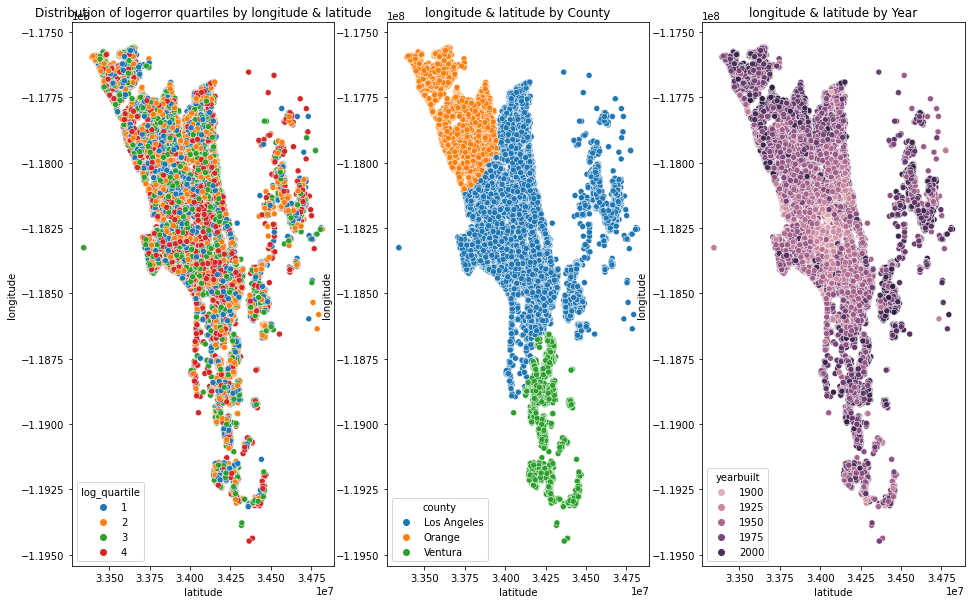

In [66]:
plt.figure(figsize=(16, 10))
plt.subplot(131)
sns.scatterplot(data=train, x=train.latitude, y=train.longitude, hue=train.log_quartile)
plt.title('Distribution of logerror quartiles by longitude & latitude')
plt.subplot(132)
sns.scatterplot(data=train, x=train.latitude, y=train.longitude, hue=train.county)
plt.title('longitude & latitude by County')
plt.subplot(133)
sns.scatterplot(data=train, x=train.latitude, y=train.longitude, hue=train.yearbuilt)
plt.title('longitude & latitude by Year')
plt.show()

***
Key Takeaways: 
* By binning the logerror we can see where the biggest misses (1st & 4th) quartile are located
    * There are some groupings we can pick up with the 4th quartile worth exploring
        * coastal areas, some pockets but not very easy to see optically
    * However, a strong grouping of 1st quartile logerror is obvious in the belly of Los Angeles County extending all the way to its southern edge
    * Logerrors in Orange County appear equally distributed with the exception of its coastal area
    * Logerrors in Ventura County appear minimal with except of its Southwestern-most point
* There appears to be some clear association b/w logerror and yearbuilt
***

## Distribution of logerror across logerror and bed/bath sqft ratios, yearbuilt & county, acrosss tax_rate & County

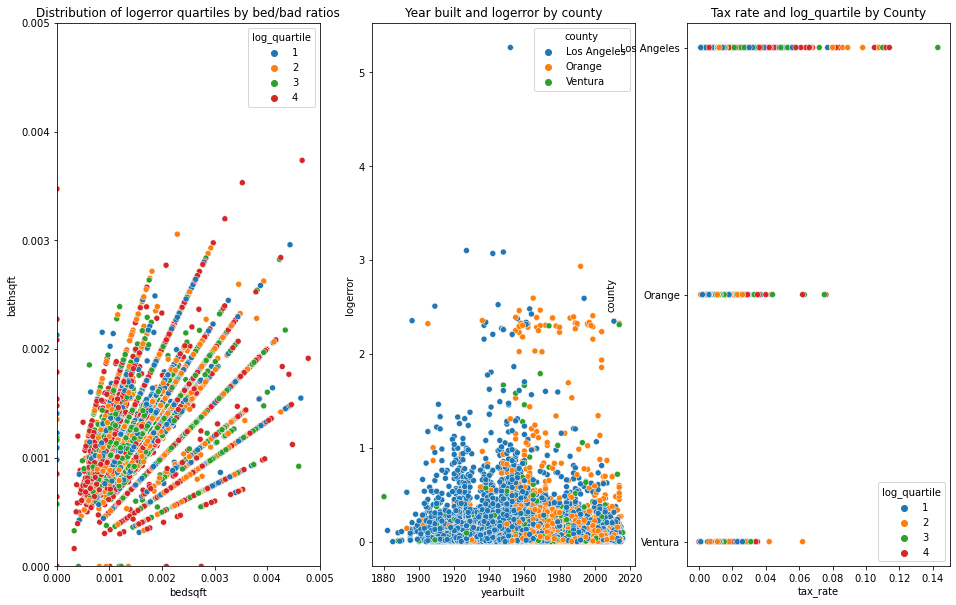

In [67]:
plt.figure(figsize=(16, 10))
plt.subplot(131)
sns.scatterplot(data=train, x=train.bedsqft, y=train.bathsqft, hue=train.log_quartile)
plt.title('Distribution of logerror quartiles by bed/bad ratios')
plt.xlim(0,.005)
plt.ylim(0,.005)
plt.subplot(132)
sns.scatterplot(data=train, x='yearbuilt', y='logerror', hue='county')
plt.title('Year built and logerror by county')
plt.subplot(133)
sns.scatterplot(data=train, x='tax_rate', y='county', hue='log_quartile')
plt.title('Tax rate and log_quartile by County')
plt.show()

***
Key Takeaways: 
* When accounting for size:
    * logerror is greater amongst smaller properties with low bath and bed to sqft ratios
    * additionally, there appears to be a ratio b/w bed/baths & sqft that leads to less logerror as in the dispersion you can see logerror rise as the ratio b/w the two gets skewed one way or the other
    * logerror appears to rise as bed/bath ratios expand
* When accounting for yearbuilt:
    * logerror appears in Los Angeles county appears to greater under 1960 whild Orange county logerrors appear to account for most of the logerror after 1960
* When accounting for tax_rate:
    * logerror appears to rise as tax_rates rise in Orange and Los Angeles Counties
***

## Distribution of logerror of logerror and bed/bath sqft ratios, yearbuilt & county by market segment

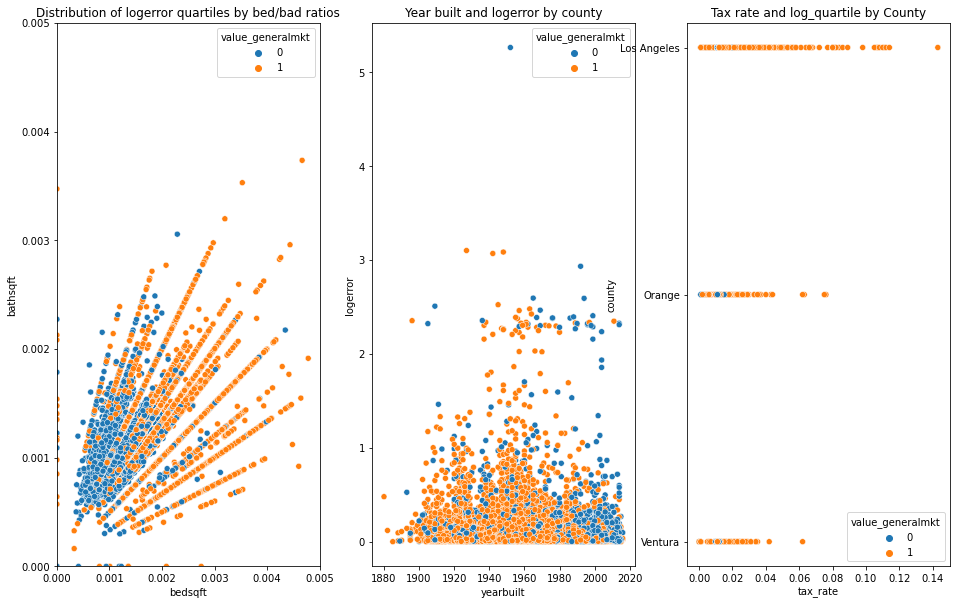

In [68]:
plt.figure(figsize=(16, 10))
plt.subplot(131)
sns.scatterplot(data=train, x=train.bedsqft, y=train.bathsqft, hue=train.value_generalmkt)
plt.title('Distribution of logerror quartiles by bed/bad ratios')
plt.xlim(0,.005)
plt.ylim(0,.005)
plt.subplot(132)
sns.scatterplot(data=train, x='yearbuilt', y='logerror', hue=train.value_generalmkt)
plt.title('Year built and logerror by county')
plt.subplot(133)
sns.scatterplot(data=train, x='tax_rate', y='county', hue=train.value_generalmkt)
plt.title('Tax rate and log_quartile by County')
plt.show()

***
Key Takeaways: 
* Breaking the data into a general and premium market:
    * illustrates that logerror is greater in lower bed/bath per sqft ratios is associated with the fact that the houses are in the premium market suggesting sqft is higher
    * shows that logerror in Los Angeles county is more associatd with age than by market segment while log error in Orange County primarily fueled by the premium market
***

## Cross comparison of market segment, loq_quartile distribution & yearbuilt by longitude/latitude

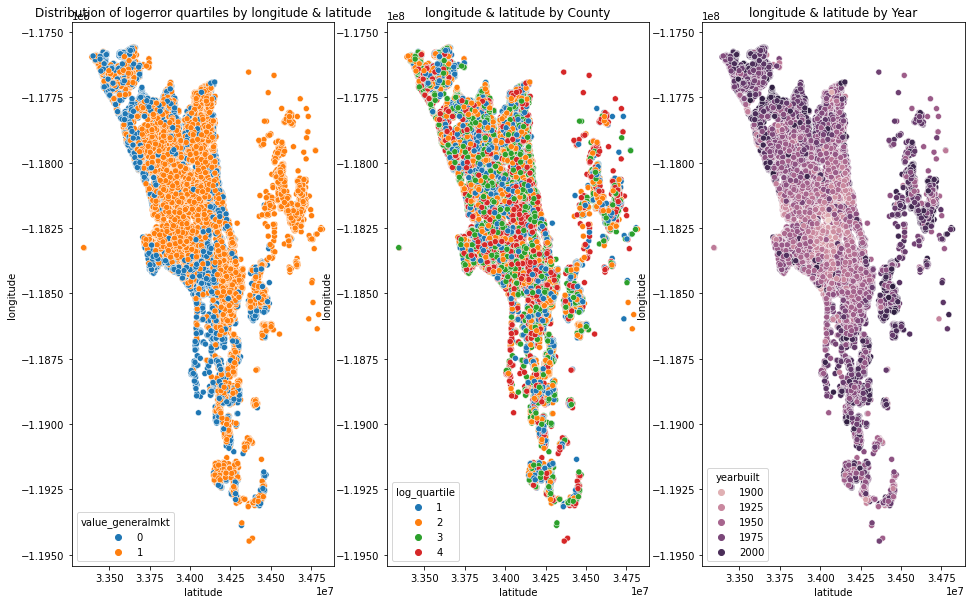

In [69]:
plt.figure(figsize=(16, 10))
plt.subplot(131)
sns.scatterplot(data=train, x=train.latitude, y=train.longitude, hue=train.value_generalmkt)
plt.title('Distribution of logerror quartiles by longitude & latitude')
plt.subplot(132)
sns.scatterplot(data=train, x=train.latitude, y=train.longitude, hue=train.log_quartile)
plt.title('longitude & latitude by County')
plt.subplot(133)
sns.scatterplot(data=train, x=train.latitude, y=train.longitude, hue=train.yearbuilt)
plt.title('longitude & latitude by Year')
plt.show()

***
Key Takeaways: 
* Breaking the data into a general and premium market by location:
    * we see that the premium market looks to have a higher correlation with logerror
        * premium maket in Los Angeles is older while Orange County much newer
***

# Clusters

In [87]:
X = train_scaled[['latitude', 'longitude', 'value_generalmkt']]

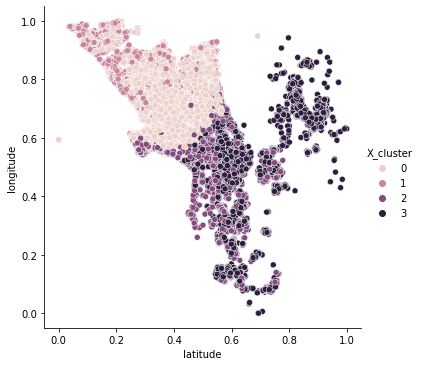

In [97]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
train_scaled['X_cluster'] = kmeans.predict(X)

sns.relplot(data=train_scaled, x='latitude', y='longitude', hue='X_cluster')

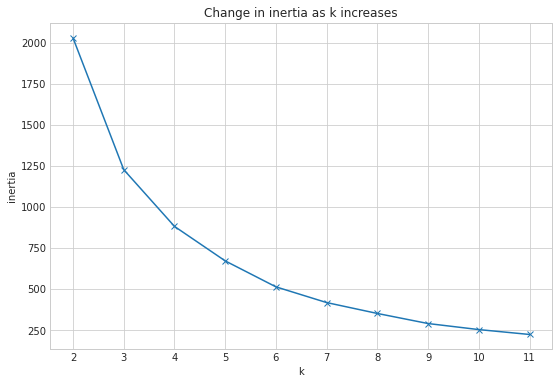

In [89]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [72]:
Y = train_scaled[['bathsqft', 'bedsqft', 'value_generalmkt']]

(0.0, 0.3)

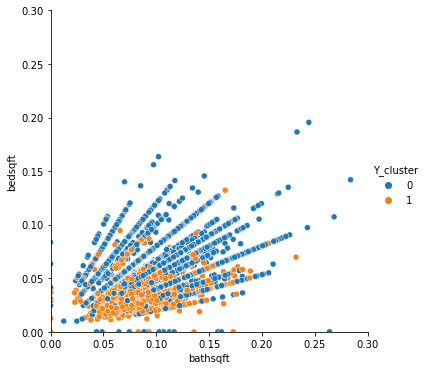

In [73]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(Y)
train_scaled['Y_cluster'] = kmeans.predict(Y)

sns.relplot(data=train_scaled, x='bathsqft', y='bedsqft', hue='Y_cluster')
plt.xlim(0,.3)
plt.ylim(0,.3)

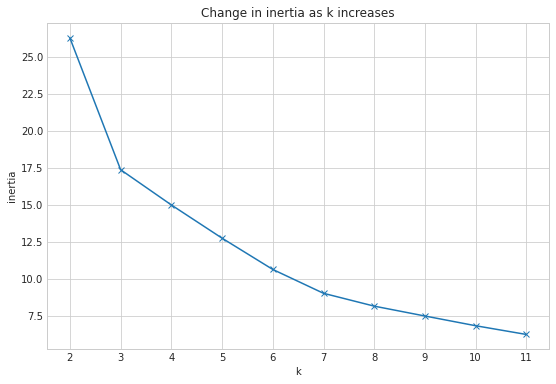

In [81]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(Y).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [74]:
Z = train_scaled[['age', 'value_generalmkt']]

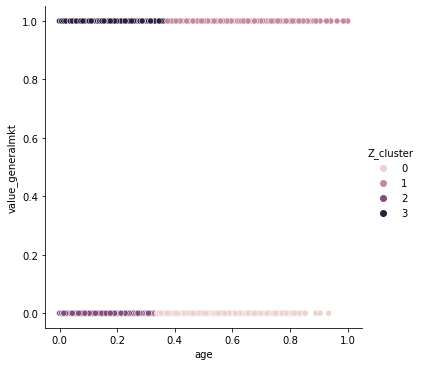

In [83]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(Z)
train_scaled['Z_cluster'] = kmeans.predict(Z)

sns.relplot(data=train_scaled, x='age', y='value_generalmkt', hue='Z_cluster')

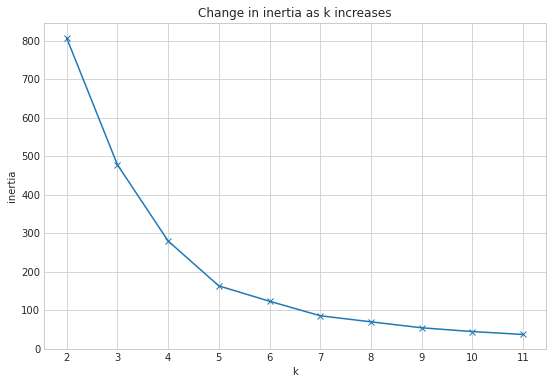

In [82]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(Z).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [76]:
W = train_scaled[['tax_rate', 'county']]

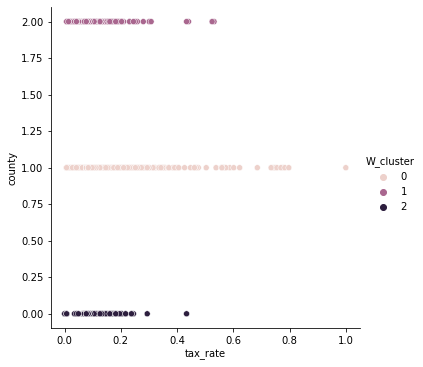

In [86]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(W)
train_scaled['W_cluster'] = kmeans.predict(W)

sns.relplot(data=train_scaled, x='tax_rate', y='county', hue='W_cluster')

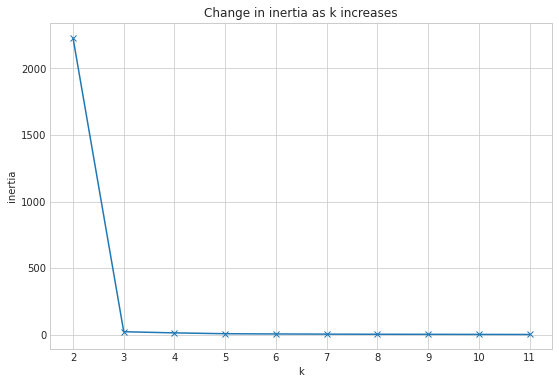

In [85]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(W).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [92]:
V = train_scaled[['latitude', 'longitude', 'age']]

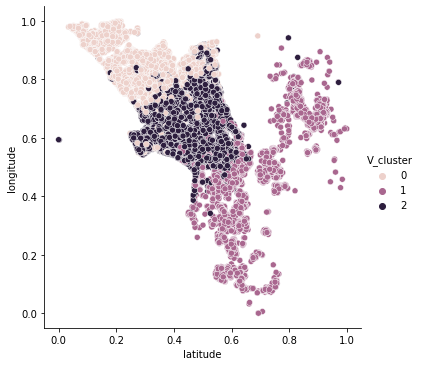

In [95]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(V)
train_scaled['V_cluster'] = kmeans.predict(V)

sns.relplot(data=train_scaled, x='latitude', y='longitude', hue='V_cluster')

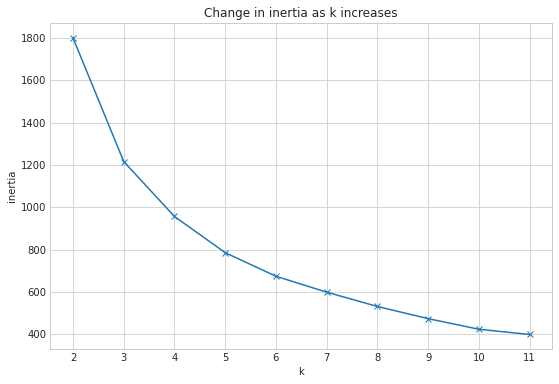

In [94]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(V).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')